### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [5]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [6]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [7]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [8]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [16]:
FEATURE_DIM = 1536

In [9]:
# fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/Inception-ResNet-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
# np.save(f'./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
# fine_tune_data.shape

(16000, 5, 1536)

In [10]:
fine_tune_data = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 1536)

In [11]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [12]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 1536)

In [13]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [14]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 1536)

In [15]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [103]:
def ftmodel():
    inputs = Input(shape=(5, FEATURE_DIM))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='Inception-RestNet-FineTune')
    return model1

In [104]:
model1 = ftmodel()
model1.summary()

Model: "Inception-RestNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 1536)]         0         
                                                                 
 flatten_6 (Flatten)         (None, 7680)              0         
                                                                 
 batch_normalization_12 (Bat  (None, 7680)             30720     
 chNormalization)                                                
                                                                 
 top_dropout_2 (Dropout)     (None, 7680)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               3932672   
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                       

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [105]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [106]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/Inception-ResNet-4P/auto-Inception-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [107]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/Inception-ResNet-4P/effnet-4p-model-weights")
model1.load_weights('./Models/Inception-ResNet-4P/effnet-4p-model-weights')

Epoch 1/1000
 1/19 [>.............................] - ETA: 7s - loss: 4.3250 - accuracy: 0.0700

2022-10-08 17:33:39.747988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.3384 - accuracy: 0.4291

2022-10-08 17:33:40.314515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 32ms/step - loss: 2.3384 - accuracy: 0.4291 - val_loss: 2.1093 - val_accuracy: 0.2950
Epoch 2/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.6381 - accuracy: 0.5522 - val_loss: 1.9532 - val_accuracy: 0.4125
Epoch 3/1000
19/19 [==============================] - 0s 19ms/step - loss: 1.4457 - accuracy: 0.6007 - val_loss: 1.9057 - val_accuracy: 0.4650
Epoch 4/1000
19/19 [==============================] - 0s 19ms/step - loss: 1.3402 - accuracy: 0.6275 - val_loss: 1.8288 - val_accuracy: 0.5312
Epoch 5/1000
19/19 [==============================] - 0s 22ms/step - loss: 1.2346 - accuracy: 0.6451 - val_loss: 1.7515 - val_accuracy: 0.5512
Epoch 6/1000
19/19 [==============================] - 0s 19ms/step - loss: 1.1689 - accuracy: 0.6634 - val_loss: 1.6648 - val_accuracy: 0.5975
Epoch 7/1000
19/19 [==============================] - 0s 20ms/step - loss: 1.1081 - accuracy: 0.6795 - val_loss: 1.5887 - val_accuracy: 0.6050
Epoch 8/1000

19/19 [==============================] - 0s 21ms/step - loss: 0.3798 - accuracy: 0.8954 - val_loss: 0.8777 - val_accuracy: 0.7725
Epoch 59/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.3750 - accuracy: 0.8981 - val_loss: 0.8854 - val_accuracy: 0.7637
Epoch 60/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.3700 - accuracy: 0.9011 - val_loss: 0.8885 - val_accuracy: 0.7637
Epoch 61/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.3576 - accuracy: 0.9063 - val_loss: 0.8753 - val_accuracy: 0.7713
Epoch 62/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.3578 - accuracy: 0.9064 - val_loss: 0.8790 - val_accuracy: 0.7662
Epoch 63/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.3531 - accuracy: 0.9053 - val_loss: 0.8688 - val_accuracy: 0.7637
Epoch 64/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.3538 - accuracy: 0.9057 - val_loss: 0.8793 - val_accuracy: 0.7600
Epoch 

Epoch 115/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.2127 - accuracy: 0.9543 - val_loss: 0.9633 - val_accuracy: 0.7800
Epoch 116/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.2118 - accuracy: 0.9543 - val_loss: 0.9515 - val_accuracy: 0.7775
Epoch 117/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.2069 - accuracy: 0.9572 - val_loss: 0.9561 - val_accuracy: 0.7725
Epoch 118/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.2066 - accuracy: 0.9558 - val_loss: 0.9507 - val_accuracy: 0.7713
Epoch 119/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.2031 - accuracy: 0.9578 - val_loss: 0.9474 - val_accuracy: 0.7763
Epoch 120/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2085 - accuracy: 0.9567 - val_loss: 0.9573 - val_accuracy: 0.7775
Epoch 121/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2085 - accuracy: 0.9560 - val_loss: 0.9667 - val_ac

19/19 [==============================] - 0s 12ms/step - loss: 0.1641 - accuracy: 0.9699 - val_loss: 1.0483 - val_accuracy: 0.7738
Epoch 172/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1635 - accuracy: 0.9718 - val_loss: 1.0604 - val_accuracy: 0.7713
Epoch 173/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1656 - accuracy: 0.9708 - val_loss: 1.0509 - val_accuracy: 0.7700
Epoch 174/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1650 - accuracy: 0.9708 - val_loss: 1.0546 - val_accuracy: 0.7812
Epoch 175/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1616 - accuracy: 0.9738 - val_loss: 1.0574 - val_accuracy: 0.7763
Epoch 176/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1616 - accuracy: 0.9730 - val_loss: 1.0389 - val_accuracy: 0.7788
Epoch 177/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1645 - accuracy: 0.9704 - val_loss: 1.0369 - val_accuracy: 0.7700


19/19 [==============================] - 0s 12ms/step - loss: 0.1458 - accuracy: 0.9805 - val_loss: 1.0780 - val_accuracy: 0.7725
Epoch 228/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1448 - accuracy: 0.9799 - val_loss: 1.0880 - val_accuracy: 0.7675
Epoch 229/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1464 - accuracy: 0.9786 - val_loss: 1.0945 - val_accuracy: 0.7750
Epoch 230/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1433 - accuracy: 0.9799 - val_loss: 1.0820 - val_accuracy: 0.7750
Epoch 231/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1481 - accuracy: 0.9790 - val_loss: 1.0909 - val_accuracy: 0.7775
Epoch 232/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.1412 - accuracy: 0.9799 - val_loss: 1.0895 - val_accuracy: 0.7750
Epoch 233/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1445 - accuracy: 0.9795 - val_loss: 1.0838 - val_accuracy: 0.7713


19/19 [==============================] - 0s 13ms/step - loss: 0.1397 - accuracy: 0.9818 - val_loss: 1.1638 - val_accuracy: 0.7738
Epoch 284/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1418 - accuracy: 0.9812 - val_loss: 1.1712 - val_accuracy: 0.7675
Epoch 285/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1377 - accuracy: 0.9822 - val_loss: 1.1819 - val_accuracy: 0.7675
Epoch 286/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1365 - accuracy: 0.9837 - val_loss: 1.1706 - val_accuracy: 0.7625
Epoch 287/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1398 - accuracy: 0.9814 - val_loss: 1.1407 - val_accuracy: 0.7725
Epoch 288/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1362 - accuracy: 0.9834 - val_loss: 1.1408 - val_accuracy: 0.7825
Epoch 289/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1415 - accuracy: 0.9812 - val_loss: 1.1535 - val_accuracy: 0.7675


19/19 [==============================] - 0s 12ms/step - loss: 0.1403 - accuracy: 0.9829 - val_loss: 1.1739 - val_accuracy: 0.7788
Epoch 340/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1331 - accuracy: 0.9859 - val_loss: 1.2012 - val_accuracy: 0.7800
Epoch 341/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1351 - accuracy: 0.9839 - val_loss: 1.2248 - val_accuracy: 0.7825
Epoch 342/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1363 - accuracy: 0.9839 - val_loss: 1.2191 - val_accuracy: 0.7875
Epoch 343/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1423 - accuracy: 0.9822 - val_loss: 1.2051 - val_accuracy: 0.7775
Epoch 344/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1393 - accuracy: 0.9818 - val_loss: 1.2183 - val_accuracy: 0.7688
Epoch 345/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1329 - accuracy: 0.9846 - val_loss: 1.1913 - val_accuracy: 0.7800


19/19 [==============================] - 0s 12ms/step - loss: 0.1386 - accuracy: 0.9849 - val_loss: 1.2319 - val_accuracy: 0.7738
Epoch 396/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1361 - accuracy: 0.9843 - val_loss: 1.2363 - val_accuracy: 0.7775
Epoch 397/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1336 - accuracy: 0.9849 - val_loss: 1.2432 - val_accuracy: 0.7750
Epoch 398/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1359 - accuracy: 0.9850 - val_loss: 1.2690 - val_accuracy: 0.7625
Epoch 399/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1344 - accuracy: 0.9859 - val_loss: 1.2498 - val_accuracy: 0.7700
Epoch 400/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1323 - accuracy: 0.9852 - val_loss: 1.2445 - val_accuracy: 0.7688
Epoch 401/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1369 - accuracy: 0.9841 - val_loss: 1.2627 - val_accuracy: 0.7713


19/19 [==============================] - 0s 12ms/step - loss: 0.1319 - accuracy: 0.9864 - val_loss: 1.2543 - val_accuracy: 0.7738
Epoch 452/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1317 - accuracy: 0.9873 - val_loss: 1.2367 - val_accuracy: 0.7775
Epoch 453/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1337 - accuracy: 0.9867 - val_loss: 1.2574 - val_accuracy: 0.7825
Epoch 454/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1343 - accuracy: 0.9859 - val_loss: 1.2596 - val_accuracy: 0.7788
Epoch 455/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1371 - accuracy: 0.9855 - val_loss: 1.2767 - val_accuracy: 0.7750
Epoch 456/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1326 - accuracy: 0.9874 - val_loss: 1.2886 - val_accuracy: 0.7688
Epoch 457/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1359 - accuracy: 0.9853 - val_loss: 1.3457 - val_accuracy: 0.7688


19/19 [==============================] - 0s 12ms/step - loss: 0.1388 - accuracy: 0.9855 - val_loss: 1.2739 - val_accuracy: 0.7700
Epoch 508/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1367 - accuracy: 0.9861 - val_loss: 1.3003 - val_accuracy: 0.7763
Epoch 509/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1343 - accuracy: 0.9868 - val_loss: 1.2972 - val_accuracy: 0.7725
Epoch 510/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1337 - accuracy: 0.9863 - val_loss: 1.2912 - val_accuracy: 0.7763
Epoch 511/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1311 - accuracy: 0.9876 - val_loss: 1.2695 - val_accuracy: 0.7763
Epoch 512/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1337 - accuracy: 0.9874 - val_loss: 1.3032 - val_accuracy: 0.7713
Epoch 513/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1363 - accuracy: 0.9852 - val_loss: 1.3150 - val_accuracy: 0.7625


19/19 [==============================] - 0s 12ms/step - loss: 0.1338 - accuracy: 0.9876 - val_loss: 1.2899 - val_accuracy: 0.7763
Epoch 564/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1358 - accuracy: 0.9868 - val_loss: 1.3075 - val_accuracy: 0.7788
Epoch 565/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1344 - accuracy: 0.9872 - val_loss: 1.2975 - val_accuracy: 0.7725
Epoch 566/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1376 - accuracy: 0.9862 - val_loss: 1.2931 - val_accuracy: 0.7725
Epoch 567/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1333 - accuracy: 0.9870 - val_loss: 1.2830 - val_accuracy: 0.7713
Epoch 568/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1361 - accuracy: 0.9864 - val_loss: 1.2832 - val_accuracy: 0.7675
Epoch 569/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1344 - accuracy: 0.9866 - val_loss: 1.3428 - val_accuracy: 0.7750


19/19 [==============================] - 0s 12ms/step - loss: 0.1324 - accuracy: 0.9883 - val_loss: 1.3003 - val_accuracy: 0.7750
Epoch 620/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1351 - accuracy: 0.9868 - val_loss: 1.2883 - val_accuracy: 0.7788
Epoch 621/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1370 - accuracy: 0.9868 - val_loss: 1.3154 - val_accuracy: 0.7700
Epoch 622/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1340 - accuracy: 0.9870 - val_loss: 1.3096 - val_accuracy: 0.7725
Epoch 623/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1353 - accuracy: 0.9872 - val_loss: 1.3096 - val_accuracy: 0.7738
Epoch 624/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1353 - accuracy: 0.9871 - val_loss: 1.2800 - val_accuracy: 0.7662
Epoch 625/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1331 - accuracy: 0.9874 - val_loss: 1.2908 - val_accuracy: 0.7750


19/19 [==============================] - 0s 12ms/step - loss: 0.1334 - accuracy: 0.9873 - val_loss: 1.3049 - val_accuracy: 0.7912
Epoch 676/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1314 - accuracy: 0.9888 - val_loss: 1.3224 - val_accuracy: 0.7825
Epoch 677/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1326 - accuracy: 0.9874 - val_loss: 1.3216 - val_accuracy: 0.7775
Epoch 678/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1326 - accuracy: 0.9882 - val_loss: 1.3250 - val_accuracy: 0.7650
Epoch 679/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1319 - accuracy: 0.9887 - val_loss: 1.3266 - val_accuracy: 0.7738
Epoch 680/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1305 - accuracy: 0.9896 - val_loss: 1.3894 - val_accuracy: 0.7750
Epoch 681/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1310 - accuracy: 0.9883 - val_loss: 1.3719 - val_accuracy: 0.7662


19/19 [==============================] - 0s 12ms/step - loss: 0.1339 - accuracy: 0.9890 - val_loss: 1.3299 - val_accuracy: 0.7738
Epoch 732/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1318 - accuracy: 0.9886 - val_loss: 1.3354 - val_accuracy: 0.7738
Epoch 733/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1304 - accuracy: 0.9887 - val_loss: 1.3337 - val_accuracy: 0.7738
Epoch 734/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1336 - accuracy: 0.9876 - val_loss: 1.3246 - val_accuracy: 0.7763
Epoch 735/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1301 - accuracy: 0.9884 - val_loss: 1.3465 - val_accuracy: 0.7688
Epoch 736/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1291 - accuracy: 0.9894 - val_loss: 1.3201 - val_accuracy: 0.7763
Epoch 737/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1360 - accuracy: 0.9870 - val_loss: 1.3367 - val_accuracy: 0.7750


19/19 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.9883 - val_loss: 1.3689 - val_accuracy: 0.7800
Epoch 788/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1338 - accuracy: 0.9878 - val_loss: 1.3438 - val_accuracy: 0.7725
Epoch 789/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1319 - accuracy: 0.9889 - val_loss: 1.3302 - val_accuracy: 0.7825
Epoch 790/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1322 - accuracy: 0.9889 - val_loss: 1.3477 - val_accuracy: 0.7788
Epoch 791/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1315 - accuracy: 0.9889 - val_loss: 1.3833 - val_accuracy: 0.7713
Epoch 792/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1333 - accuracy: 0.9878 - val_loss: 1.3918 - val_accuracy: 0.7738
Epoch 793/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1305 - accuracy: 0.9887 - val_loss: 1.4074 - val_accuracy: 0.7750


19/19 [==============================] - 0s 13ms/step - loss: 0.1320 - accuracy: 0.9886 - val_loss: 1.3741 - val_accuracy: 0.7700
Epoch 844/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1318 - accuracy: 0.9878 - val_loss: 1.3603 - val_accuracy: 0.7650
Epoch 845/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1310 - accuracy: 0.9876 - val_loss: 1.3760 - val_accuracy: 0.7738
Epoch 846/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1304 - accuracy: 0.9885 - val_loss: 1.4185 - val_accuracy: 0.7650
Epoch 847/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1331 - accuracy: 0.9874 - val_loss: 1.3589 - val_accuracy: 0.7700
Epoch 848/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1320 - accuracy: 0.9882 - val_loss: 1.3892 - val_accuracy: 0.7713
Epoch 849/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1343 - accuracy: 0.9869 - val_loss: 1.3527 - val_accuracy: 0.7812


19/19 [==============================] - 0s 12ms/step - loss: 0.1314 - accuracy: 0.9886 - val_loss: 1.3763 - val_accuracy: 0.7738
Epoch 900/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1316 - accuracy: 0.9896 - val_loss: 1.3656 - val_accuracy: 0.7750
Epoch 901/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1308 - accuracy: 0.9893 - val_loss: 1.3820 - val_accuracy: 0.7700
Epoch 902/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1346 - accuracy: 0.9874 - val_loss: 1.3593 - val_accuracy: 0.7788
Epoch 903/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.9880 - val_loss: 1.3544 - val_accuracy: 0.7812
Epoch 904/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1302 - accuracy: 0.9886 - val_loss: 1.3401 - val_accuracy: 0.7775
Epoch 905/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1352 - accuracy: 0.9870 - val_loss: 1.3620 - val_accuracy: 0.7675


19/19 [==============================] - 0s 12ms/step - loss: 0.1280 - accuracy: 0.9897 - val_loss: 1.3363 - val_accuracy: 0.7713
Epoch 956/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1294 - accuracy: 0.9893 - val_loss: 1.3375 - val_accuracy: 0.7750
Epoch 957/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1289 - accuracy: 0.9896 - val_loss: 1.3549 - val_accuracy: 0.7763
Epoch 958/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1284 - accuracy: 0.9901 - val_loss: 1.3745 - val_accuracy: 0.7800
Epoch 959/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1290 - accuracy: 0.9897 - val_loss: 1.3457 - val_accuracy: 0.7775
Epoch 960/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1311 - accuracy: 0.9901 - val_loss: 1.3650 - val_accuracy: 0.7637
Epoch 961/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1303 - accuracy: 0.9896 - val_loss: 1.3598 - val_accuracy: 0.7675


In [130]:
model1.load_weights('./Models/Inception-ResNet-4P/auto-Inception-ResNet-FT-model-weight')

In [131]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

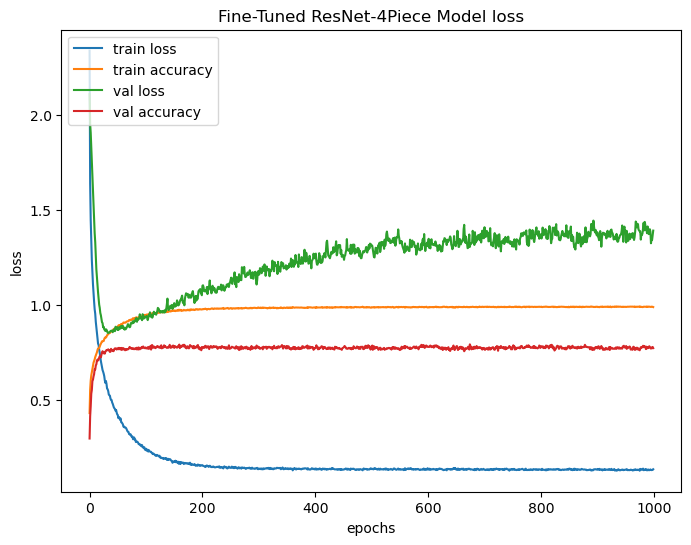

In [132]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [133]:
train_preds = model1.predict(fine_tune_data_train)

475/475 [==============================] - 1s 3ms/step


In [134]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [135]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [136]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [137]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [138]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [139]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 3ms/step


In [140]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [141]:
test_pred_labels

array([11,  8,  0,  7, 10,  6, 13,  4, 14,  1,  6, 15,  7, 14, 13, 11,  0,
        4,  6, 12,  8, 14,  3, 12,  6,  0,  3,  8,  3,  3, 11,  1,  9,  2,
       13,  8,  4,  7, 11,  9,  6, 12, 14,  2,  5, 14,  5, 15, 13,  4,  0,
       10,  5, 12, 11, 14, 15,  9,  9,  2, 15,  9, 11, 11,  6,  5,  8,  9,
        6,  3,  4,  4, 12, 12,  8,  6,  7,  6, 12,  0, 11, 15, 12, 12,  9,
        8, 13, 13,  3, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 10,
        9,  9, 10, 14,  8,  2,  5,  5,  7,  5,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1,  0, 12,  1,  5, 10, 12, 15, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8, 10,  8,  9,  2, 13,  0, 14,  4,
       14,  4,  9,  4, 14,  7, 11,  8,  4,  4, 10,  5,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 10, 10, 11, 11, 11,  1,  9,  1,
        9,  2, 13,  7, 12,  1,  4,  8,  7,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  0,  7, 10

In [142]:
np.sum(test_pred_labels == test_labels['label'])

608

In [143]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
782,15582,./Data/train/train/15582.tif,3
785,15621,./Data/train/train/15621.tif,15


In [144]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.603774,0.592593,0.598131,54
1,0.657895,0.568182,0.609756,44
2,0.883721,0.883721,0.883721,43
3,0.893617,0.913043,0.903226,46
4,0.875000,0.972222,0.921053,36
5,0.627907,0.540000,0.580645,50
6,0.863636,0.826087,0.844444,46
7,0.833333,0.769231,0.800000,52
8,0.854839,0.981481,0.913793,54
9,0.791667,0.808511,0.800000,47


In [145]:
np.mean(fscore)

0.7615452418406187

#### On Validation Data

Generating Predictions for the Validation Set

In [124]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [125]:
fine_tune_data_validation = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 5, 1536)

In [126]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-08 17:37:56.280589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [127]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [128]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,1
896,18697,12
897,18698,8
898,18699,3


In [129]:
submission_data.to_csv('./Submissions/submission-inception-resnet-4p.csv', index=False)